# Population and Demographic Analysis Tutorial

This Jupyter Notebook provides a step-by-step guide for analyzing population data and demographics within a user-defined Area of Interest (AOI). Using interactive widgets and map visualizations, you can:

- **Interactively Select an AOI:** Draw or choose a polygon region directly on an interactive map widget.
- **Query Population Data:** Fetch demographic data (e.g., total population, age, and gender distributions).
- **Visualize Demographics with Population Pyramids:** Create age-gender pyramids to understand the demographic structure of the selected AOI, which can be especially valuable in high-conflict or vulnerable regions.
- **Map-Based Exploration:** View spatial distributions of population data across hexagonal units to visualize which areas have higher population counts and how demographics vary spatially.

In [11]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import json
import ipywidgets as widgets
from ipyleaflet import Map, DrawControl

In [12]:
BASE_URL = "https://w7tfg3g781.execute-api.us-east-1.amazonaws.com/"
FIELDS_ENDPOINT = f"{BASE_URL}/fields"
SUMMARY_ENDPOINT = f"{BASE_URL}/summary"

In [25]:
# Center the map in your region of interest
m = Map(center=(4.0, 33.0), zoom=6)

draw_control = DrawControl(
    polygon = {
        "shapeOptions": {
            "color": "#6e6d6b",
            "weight": 2,
            "fillOpacity": 0.5
        },
        "drawError": {
            "color": "#dd253b",
            "message": "Error drawing shape!"
        },
    },
    rectangle = {
        "shapeOptions": {
            "color": "#6e6d6b",
            "weight": 2,
            "fillOpacity": 0.5
        }
    },
    circlemarker={},
    polyline={},
    marker={}
)

user_aoi = None

def handle_draw(self, action, geo_json):
    global user_aoi
    user_aoi = geo_json
    print("AOI captured:")
    print(json.dumps(user_aoi, indent=2))
    
    # Convert to a shapely geometry
    geom = shape(geo_json['geometry'])
    print("Area (approx.):", geom.area, "square degrees")

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

m

Map(center=[4.0, 33.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [26]:
aoi_geojson = {
    "type": "Feature",
    "geometry": user_aoi['geometry'],
    "properties": {"name": "User Selected AOI"}
}

In [27]:
# Define which fields to request. Here we select both male and female at specific age intervals
age_groups = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
female_fields = [f"sum_pop_f_{a}_2020" for a in age_groups]
male_fields = [f"sum_pop_m_{a}_2020" for a in age_groups]

In [28]:
# Add total population fields if desired
fields = ["sum_pop_2020", "sum_pop_f_2020", "sum_pop_m_2020"] + female_fields + male_fields

request_payload = {
    "aoi": aoi_geojson,
    "spatial_join_method": "touches",
    "fields": fields,
    "geometry": "polygon",
}

In [32]:
# Make the POST request
response = requests.post(SUMMARY_ENDPOINT, json=request_payload)
if response.status_code != 200:
    raise Exception(f"Failed to get summary: {response.status_code} {response.text}. Try selecting a smaller AOI or requesting less fields")
summary_data = response.json()

# Convert to DataFrame
df = pd.DataFrame(summary_data)

In [30]:
# Convert geometry from GeoJSON string to Shapely geometry
df["geometry"] = df["geometry"].apply(lambda geom: shape(json.loads(geom)) if isinstance(geom, str) else shape(geom))

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Plot on Map
m = gdf.explore(
    column="sum_pop_2020",
    tooltip="sum_pop_2020",
    cmap="YlGnBu",
    legend=True,
    scheme="naturalbreaks",
    legend_kwds=dict(colorbar=True, caption="Population", interval=False),
    style_kwds=dict(weight=0, fillOpacity=0.8),
    name="Population by Hexagon",
)

m

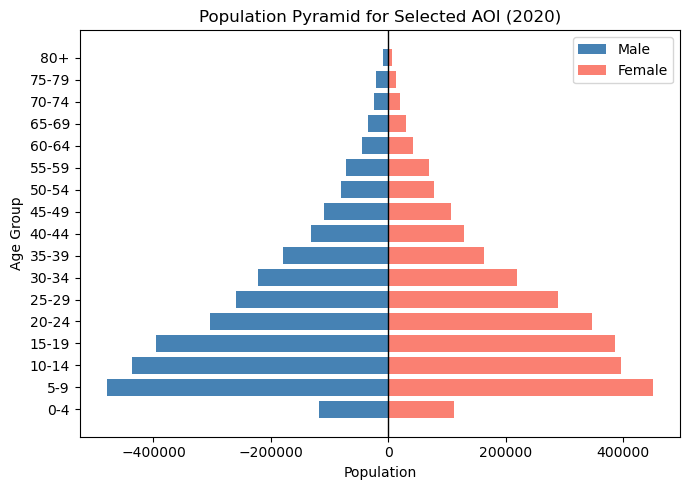

In [33]:
# Let's aggregate:
agg_fields = female_fields + male_fields
pyramid_data = df[agg_fields].sum()  # Summation across all returned polygons

# Prepare data for plotting
male_pop = [pyramid_data[f"sum_pop_m_{a}_2020"] for a in age_groups]
female_pop = [pyramid_data[f"sum_pop_f_{a}_2020"] for a in age_groups]

# Create a DataFrame for easier plotting
plot_df = pd.DataFrame({
    "AgeGroup": [f"{a}-{a+4}" if a<80 else "80+" for a in age_groups],
    "Male": male_pop,
    "Female": female_pop
})

# Plotting the Pyramid
fig, ax = plt.subplots(figsize=(7,5))

# Plot males as negative for symmetry
ax.barh(plot_df["AgeGroup"], -plot_df["Male"], color="steelblue", label="Male")
ax.barh(plot_df["AgeGroup"], plot_df["Female"], color="salmon", label="Female")

ax.set_xlabel("Population")
ax.set_ylabel("Age Group")
ax.set_title("Population Pyramid for Selected AOI (2020)")

# Make x-ticks positive labels, even though males are negative in the data
ax.axvline(0, color="black", linewidth=1)
ax.legend()

plt.tight_layout()
plt.show()
